In [11]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'No'),
  Text(1, 0, 'year'),
  Text(2, 0, 'month'),
  Text(3, 0, 'day'),
  Text(4, 0, 'hour'),
  Text(5, 0, 'pm2.5'),
  Text(6, 0, 'DEWP'),
  Text(7, 0, 'TEMP'),
  Text(8, 0, 'PRES'),
  Text(9, 0, 'cbwd'),
  Text(10, 0, 'Iws'),
  Text(11, 0, 'Is'),
  Text(12, 0, 'Ir')])

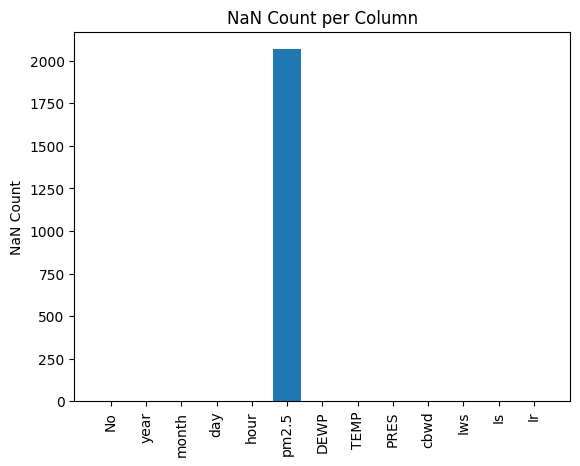

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")


# Count NaNs
nan_counts = df.isna().sum()

# Plot
plt.figure()
bars = plt.bar(nan_counts.index, nan_counts.values)

plt.title("NaN Count per Column")
plt.ylabel("NaN Count")
plt.xticks(rotation=90)

# Add count

In [13]:
df = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")

df.head()


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


Create Datetime Index

In [14]:
df["datetime"] = pd.to_datetime(
    df[["year", "month", "day", "hour"]]
)
df = df.set_index("datetime").sort_index()


EDA: Fill in Missing pm2.5 values

In [15]:
df["pm25_missing"] = df["pm2.5"].isna().astype(int)

df["pm2.5"] = df["pm2.5"].fillna(method="ffill").fillna(method="bfill")


/tmp/ipython-input-4178109737.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["pm2.5"] = df["pm2.5"].fillna(method="ffill").fillna(method="bfill")


Add Cyclical Time Features

In [16]:
df["hour_sin"] = np.sin(2 * np.pi * df.index.hour / 24)
df["hour_cos"] = np.cos(2 * np.pi * df.index.hour / 24)

df["dow_sin"] = np.sin(2 * np.pi * df.index.dayofweek / 7)
df["dow_cos"] = np.cos(2 * np.pi * df.index.dayofweek / 7)


Select Features & Target

In [17]:
target = "pm2.5"

features = [
    "DEWP", "TEMP", "PRES", "Iws", "Is", "Ir",
    "pm25_missing",
    "hour_sin", "hour_cos", "dow_sin", "dow_cos"
]

df_model = df[features + [target]].dropna()


Scale Data

In [18]:
scaler_x = RobustScaler()
scaler_y = RobustScaler()

X_scaled = scaler_x.fit_transform(df_model[features])
y_scaled = scaler_y.fit_transform(df_model[[target]])


Create Time Series Sequences

In [19]:
def make_sequences(X, y, window=24):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

WINDOW = 24  # past 24 hours
X_seq, y_seq = make_sequences(X_scaled, y_scaled, WINDOW)


# Train/Validation/Test Split

In [35]:
n = len(X_seq)

train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train, y_train = X_seq[:train_end], y_seq[:train_end]
X_val, y_val     = X_seq[train_end:val_end], y_seq[train_end:val_end]
X_test, y_test   = X_seq[val_end:], y_seq[val_end:]


# LSTM Model

In [106]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW, X_train.shape[2])),
    LSTM(32),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.Huber(),
    metrics=["mae"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,905 (124.63 KB)

 Trainable params: 31,905 (124.63 KB)

 Non-trainable params: 0 (0.00 B)

Training

In [107]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)



Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.1984 - mae: 0.4781 - val_loss: 0.2088 - val_mae: 0.4634
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.1461 - mae: 0.3971 - val_loss: 0.2003 - val_mae: 0.4726
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1304 - mae: 0.3709 - val_loss: 0.2070 - val_mae: 0.4811
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.1182 - mae: 0.3484 - val_loss: 0.1867 - val_mae: 0.4473
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.1074 - mae: 0.3293 - val_loss: 0.2055 - val_mae: 0.4728
Epoch 6/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1002 - mae: 0.3131 - val_loss: 0.2133 - val_mae: 0.4698
Epoch 7/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0821 - mae: 0.2821 - val_loss: 0.2073 - val_mae: 0.4632
Epoch 8/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0751 - mae: 0.2685 - val_loss: 0.1926 - val_mae: 0.4561
Epoch 9/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step -

# Testing

In [149]:
y_pred = model.predict(X_test)

y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

lstm_mse = mean_squared_error(y_test_inv, y_pred_inv)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_inv, y_pred_inv)

y_true = y_test_inv.reshape(-1)
y_pred = y_pred_inv.reshape(-1)
true_diff = np.diff(y_true)
pred_diff = np.diff(y_pred)

lstm_directional_accuracy = np.mean(
    np.sign(true_diff) == np.sign(pred_diff)
)

print(f"Test RMSE: {lstm_rmse:.2f}")
print(f"Test MAE: {lstm_mae:.2f}")
print(f"Directional Accuracy: {lstm_directional_accuracy * 100:.2f}%")


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test RMSE: 62.75
Test MAE: 46.33
Directional Accuracy: 54.97%


# Simple RNN Model

In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping

rnn_model = Sequential([
    SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

rnn_model.compile(
    optimizer="adam",
    loss="mse"
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Train the RNN

In [110]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.4841 - val_loss: 0.4300
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3940 - val_loss: 0.4101
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3970 - val_loss: 0.4190
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3756 - val_loss: 0.4746
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3665 - val_loss: 0.4756
Epoch 6/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3465 - val_loss: 0.4731
Epoch 7/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3201 - val_loss: 0.4707


Test Evaluation

In [150]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_pred_scaled = rnn_model.predict(X_test)

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

rnn_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rnn_mae = mean_absolute_error(y_true, y_pred)

y_true = y_test_inv.reshape(-1)
y_pred = y_pred_inv.reshape(-1)
true_diff = np.diff(y_true)
pred_diff = np.diff(y_pred)

rnn_directional_accuracy = np.mean(
    np.sign(true_diff) == np.sign(pred_diff)
)

print("Simple RNN Test RMSE:", rnn_rmse)
print("Simple RNN Test MAE:", rnn_mae)
print(f"Directional Accuracy: {rnn_directional_accuracy * 100:.2f}%")

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Simple RNN Test RMSE: 60.991631133132366
Simple RNN Test MAE: 46.44212227506362
Directional Accuracy: 54.97%


# GRU Model

In [151]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

gru_model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

gru_model.compile(
    optimizer="adam",
    loss="mse"
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Training GRU

In [152]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True)

gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1)


Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.4934 - val_loss: 0.5241
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3854 - val_loss: 0.4607
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.3641 - val_loss: 0.5055
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.3204 - val_loss: 0.4228
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.2884 - val_loss: 0.4614
Epoch 6/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2899 - val_loss: 0.4164
Epoch 7/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.2611 - val_loss: 0.4695
Epoch 8/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.2500 - val_loss: 0.4974
Epoch 9/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.2408 - val_loss: 0.5064
Epoch 10/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.2248 - val_loss: 0.4797
Epoch 11/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.2118 - val_loss: 0.4553


# Testing GRU

In [153]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_pred_scaled = gru_model.predict(X_test)

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

gru_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
gru_mae = mean_absolute_error(y_true, y_pred)

y_true = y_test_inv.reshape(-1)
y_pred = y_pred_inv.reshape(-1)
true_diff = np.diff(y_true)
pred_diff = np.diff(y_pred)

gru_directional_accuracy = np.mean(
    np.sign(true_diff) == np.sign(pred_diff)
)


print("GRU Test RMSE:", gru_rmse)
print("GRU Test MAE:", gru_mae)
print(f"Directional Accuracy: {gru_directional_accuracy * 100:.2f}%")

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
GRU Test RMSE: 58.863558423232526
GRU Test MAE: 44.93193306131813
Directional Accuracy: 54.97%


# Comparing all 3 Models

In [156]:
rmse_table = pd.DataFrame({
    "Model": ["Simple RNN", "LSTM", "GRU"],
    "Test RMSE (PM2.5)": [rnn_rmse, lstm_rmse, gru_rmse],
    "Test MAE (PM2.5)": [rnn_mae, lstm_mae, gru_mae],
    "Directional Accuracy (%)": [rnn_directional_accuracy*100, lstm_directional_accuracy*100, gru_directional_accuracy*100]
    })

rmse_table

,Model,Test RMSE (PM2.5),Test MAE (PM2.5),Directional Accuracy (%)
0,Simple RNN,60.991631,46.442122,54.970315
1,LSTM,62.753978,46.328323,54.970315
2,GRU,58.863558,44.931933,54.970315


# Our Model

In [142]:
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l2

gru_model1 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    GRU(
        96,
        return_sequences=True,
        activation="tanh",
        kernel_regularizer=l2(5e-5),
        recurrent_regularizer=l2(5e-5)
    ),
    LayerNormalization(),
    Dropout(0.35),

    GRU(
        48,
        activation="tanh",
        kernel_regularizer=l2(5e-5),
        recurrent_regularizer=l2(5e-5)
    ),
    LayerNormalization(),
    Dropout(0.30),

    Dense(32, activation="relu", kernel_regularizer=l2(5e-5)),
    Dropout(0.25),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0)

gru_model1.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.Huber(delta=1.0),
    metrics=["mae"]
)

gru_model1.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_16 (GRU)                    │ (None, 24, 96)         │        31,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_40          │ (None, 24, 96)         │           192 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 24, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_17 (GRU)                    │ (None, 48)             │        21,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_41          │ (None, 48)             │            96 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,305 (212.13 KB)

 Trainable params: 54,305 (212.13 KB)

 Non-trainable params: 0 (0.00 B)

In [143]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath="best_gru_val_mae.keras",
    monitor="val_mae",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_mae",
    mode="min",
    patience=5,
    restore_best_weights=True
)

history = gru_model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

# Load the best saved model (by val_mae)
best_model = tf.keras.models.load_model("best_gru_val_mae.keras")


Epoch 1/50
957/959 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3619 - mae: 0.6843
Epoch 1: val_mae improved from inf to 0.50528, saving model to best_gru_val_mae.keras
959/959 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.3617 - mae: 0.6840 - val_loss: 0.2380 - val_mae: 0.5053
Epoch 2/50
958/959 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2234 - mae: 0.5026
Epoch 2: val_mae improved from 0.50528 to 0.50376, saving model to best_gru_val_mae.keras
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.2234 - mae: 0.5026 - val_loss: 0.2380 - val_mae: 0.5038
Epoch 3/50
958/959 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1986 - mae: 0.4665
Epoch 3: val_mae did not improve from 0.50376
959/959 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.1986 - mae: 0.4665 - val_loss: 0.2424 - val_mae: 0.5093
Epoch 4/50
956/959 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1909 - mae: 0.4550
Epoch 4: val_mae improved from 0.50376 to 0.46770, saving model to best_gru_val_mae.keras
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 

In [144]:
best_model = tf.keras.models.load_model("best_gru_val_mae.keras")
y_pred = best_model.predict(X_test)

y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

gru1_mse = mean_squared_error(y_test_inv, y_pred_inv)
gru1_rmse = np.sqrt(gru1_mse)
gru1_mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f"Test RMSE: {gru1_rmse:.2f}")
print(f"Test MAE: {gru1_mae:.2f}")

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test RMSE: 56.56
Test MAE: 40.05


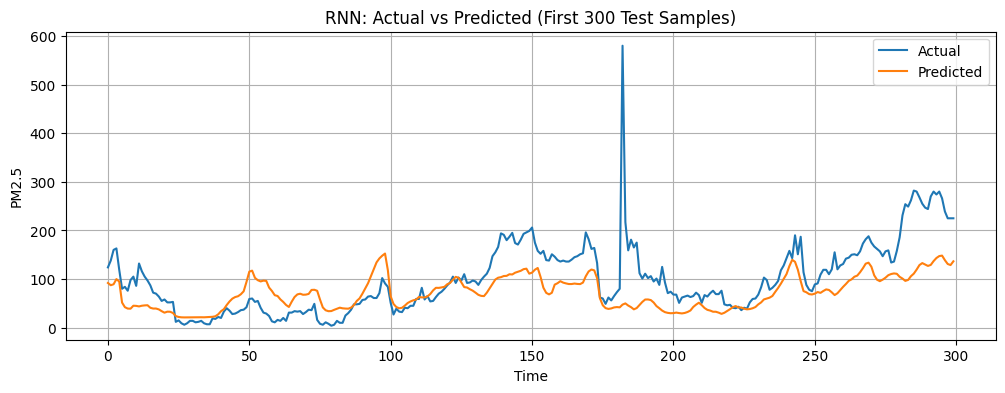

RNN Test RMSE: 56.55708401687593


In [145]:
y_pred = best_model.predict(X_test, verbose=0)

y_pred = y_pred.reshape(-1, 1)
y_true = y_test.reshape(-1, 1)

y_pred_inv = scaler_y.inverse_transform(y_pred)
y_true_inv = scaler_y.inverse_transform(y_true)

plt.figure(figsize=(12, 4))
plt.plot(y_true_inv[:300], label="Actual")
plt.plot(y_pred_inv[:300], label="Predicted")
plt.title("RNN: Actual vs Predicted (First 300 Test Samples)")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.legend()
plt.grid(True)
plt.show()

rmse = np.sqrt(np.mean((y_true_inv - y_pred_inv) ** 2))

In [148]:
y_true = y_test_inv.reshape(-1)
y_pred = y_pred_inv.reshape(-1)
true_diff = np.diff(y_true)
pred_diff = np.diff(y_pred)

directional_accuracy = np.mean(
    np.sign(true_diff) == np.sign(pred_diff))

Directional Accuracy: 54.15%


In [158]:
print(f"Directional Accuracy: {directional_accuracy * 100:.2f}%")

Directional Accuracy: 57.15%


In [ ]:
# Final Results

In [162]:
rmse_table = pd.DataFrame({
    "Model": ["Simple RNN", "LSTM", "GRU", "GRU Fine Tune"],
    "Test RMSE (PM2.5)": [rnn_rmse, lstm_rmse, gru_rmse,gru1_rmse],
    "Test MAE (PM2.5)": [rnn_mae, lstm_mae, gru_mae,gru1_mae],
    "Directional Accuracy (%)": [rnn_directional_accuracy*100, lstm_directional_accuracy*100, gru_directional_accuracy*100, directional_accuracy*100]
    })
rmse_table

,Model,Test RMSE (PM2.5),Test MAE (PM2.5),Directional Accuracy (%)
0,Simple RNN,60.991631,46.442122,54.970315
1,LSTM,62.753978,46.328323,54.970315
2,GRU,58.863558,44.931933,54.970315
3,GRU Fine Tune,56.557084,40.046923,57.148272
